In [377]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformer_lens import HookedTransformer, HookedTransformerConfig, utils
import random
import circuitsvis as cv
from fancy_einsum import einsum

In [378]:
# model parameter constants
N_LAYERS = 1
N_HEADS = 1
D_MODEL = 32
D_HEAD = 32
D_MLP = None
# D_VOCAB = 12
D_VOCAB = 66
SEED = 123
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# DEVICE = torch.device("mps")

In [379]:
MAX_DIGITS = 5
NUM_DIGITS = 2
# 10 is between numbers, 11 for filler space
# CTX_LEN = (1 + NUM_DIGITS) * MAX_DIGITS + (NUM_DIGITS)
CTX_LEN = MAX_DIGITS * 3 + 2

In [380]:
def generate_number_with_variable_length(max_digits):
    num_digits = random.randint(1, max_digits)
    if num_digits == 1:
        return random.randint(0, 9), num_digits  # For a single digit, range is 0-9
    else:
        return random.randint(10**(num_digits-1), 10**num_digits - 1), num_digits

def generate_data(n, seen, training=True):
    # random.seed(42 if training else 100)
    tokens = []
    target = []

    for _ in range(n):
        curr = []
        answer = ""
        
        a, len_a = (generate_number_with_variable_length(MAX_DIGITS))
        b, len_b = (generate_number_with_variable_length(MAX_DIGITS))

        if training:
            seen.add((a, b))
            seen.add((b, a))

        if not training:
            while (a, b) in seen or (b, a) in seen:
                a, len_a = (generate_number_with_variable_length(MAX_DIGITS))
                b, len_b = (generate_number_with_variable_length(MAX_DIGITS))
        # a = random.randint(0, 99999)
        # b = random.randint(0, 99999)
        # len_a = len(str(a))
        # len_b = len(str(b))

        if a > b:
            answer = "a"
        else:
            answer = "b"
        curr.append(64)

        for i in range(MAX_DIGITS - len_a):
            curr.append(0)
        for digit in str(a):
            curr.append(int(digit))
                
        for i in range(MAX_DIGITS - len_b):
            curr.append(0)
        for digit in str(b):
            curr.append(int(digit))
        
        if answer == "a":
            answer_list = curr[1:MAX_DIGITS+1]
        else:
            answer_list = curr[MAX_DIGITS+1:]

        curr.append(65)
        for ans in answer_list:
            curr.append(0)
        
        tokens.append(curr)
        target.append(answer_list)

    return torch.tensor(tokens), torch.tensor(target)

generate_data(10, set())

(tensor([[64,  0,  0,  8,  1,  6,  0,  0,  0,  8,  9, 65,  0,  0,  0,  0,  0],
         [64,  0,  0,  2,  2,  7,  0,  0,  0,  3,  3, 65,  0,  0,  0,  0,  0],
         [64,  0,  6,  8,  9,  9,  1,  6,  2,  5,  3, 65,  0,  0,  0,  0,  0],
         [64,  0,  0,  3,  8,  3,  0,  0,  0,  0,  2, 65,  0,  0,  0,  0,  0],
         [64,  0,  0,  0,  0,  3,  0,  7,  1,  4,  6, 65,  0,  0,  0,  0,  0],
         [64,  0,  0,  3,  2,  6,  9,  5,  1,  4,  3, 65,  0,  0,  0,  0,  0],
         [64,  0,  0,  0,  0,  4,  5,  2,  8,  8,  0, 65,  0,  0,  0,  0,  0],
         [64,  7,  4,  9,  9,  2,  2,  8,  0,  5,  7, 65,  0,  0,  0,  0,  0],
         [64,  0,  0,  0,  0,  9,  0,  0,  0,  6,  8, 65,  0,  0,  0,  0,  0],
         [64,  0,  9,  3,  6,  1,  2,  3,  5,  4,  6, 65,  0,  0,  0,  0,  0]]),
 tensor([[0, 0, 8, 1, 6],
         [0, 0, 2, 2, 7],
         [1, 6, 2, 5, 3],
         [0, 0, 3, 8, 3],
         [0, 7, 1, 4, 6],
         [9, 5, 1, 4, 3],
         [5, 2, 8, 8, 0],
         [7, 4, 9, 9, 2],


In [381]:
# model setup

# MIGHT HAVE TO CHANGE CONTEXT OR VOCAB
cfg = HookedTransformerConfig(
    d_model=D_MODEL,
    n_layers=N_LAYERS,
    n_heads=N_HEADS,
    d_head=D_HEAD,
    n_ctx=CTX_LEN,
    d_vocab=D_VOCAB,
    act_fn="relu",
    seed=SEED,
    device=DEVICE,
    attn_only=True,
)

# hooked transformer used for interpretation later
model = HookedTransformer(cfg, move_to_device=True)
# model.to(DEVICE)

In [382]:
def loss_function(logits, target, return_per_token=True, print_tokens=False):
    answer = target
    # print(logits.shape)
    predict_start_location = 2 * MAX_DIGITS + 2
    logits = logits[:, predict_start_location - 1 : , :]
    # print(logits.shape)
    log_prob = logits.log_softmax(-1)
    output_prob = log_prob.gather(-1, answer[..., None])[..., 0]

    # mask = (target != 11).float()
    # masked_output_prob = output_prob * mask

    if print_tokens:
        print("target", target)
        print("predicted", torch.argmax(logits, dim=-1))
        # print(answer.unsqueeze(-1))
        # print(output_prob)
        
    if return_per_token:
        # return -(masked_output_prob / mask.sum(dim=1, keepdim=True).clamp(min=1))
        return -output_prob
    # return -(masked_output_prob.sum() / mask.sum())
    return -output_prob.mean()

In [383]:
def accuracy(logits, target, return_per_token=False):
    logits = logits[:, 2 * MAX_DIGITS + 2:, :]
    predicted = torch.argmax(logits, dim=-1)
    answer = target
    # print(predicted, answer)
    if return_per_token:
        return (predicted == answer).float()
    return (predicted == answer).float().mean().item()

In [384]:
import torch
import torch.nn as nn
import numpy as np

def train_model(model, n_epochs, batch_size, batches_per, sequence_length=2):
    lr = 1e-3
    betas = (0.9, 0.999)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=betas)
    
    vocab_size = 12 
    train_losses = []
    seen = set()
    # model.train()
    for epoch in range(n_epochs):
        epoch_losses = []

        model.train()
        for _ in range(batches_per):
            tokens, targets = generate_data(batch_size, seen, training=True) 
            logits = model(tokens)
            
            # print(tokens)
            losses = loss_function(logits, targets, print_tokens=False)
            
            losses.mean().backward()
            optimizer.step()
            optimizer.zero_grad()
            
            epoch_losses.extend(losses.detach())

        # epoch_losses_cpu = [loss.cpu().numpy() for loss in epoch_losses]
        train_losses.append(np.mean(epoch_losses))
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, train loss: {train_losses[-1]}")

        model.eval()

        test_data, targets = generate_data(1280, seen, training=False)
        logits = model(test_data)

        acc = accuracy(logits, targets, return_per_token=False)

        if epoch % 10 == 0:
            print(f"Validation {epoch} accuracy: {acc}")

    return train_losses, seen


In [385]:
torch.set_printoptions(threshold=10000)
losses, seen = train_model(model, 100, 128, 10)

Epoch 0, train loss: 3.5447351932525635
Validation 0 accuracy: 0.27671873569488525
Epoch 10, train loss: 1.7340582609176636
Validation 10 accuracy: 0.5142187476158142
Epoch 20, train loss: 0.40721452236175537
Validation 20 accuracy: 0.7989062666893005
Epoch 30, train loss: 0.3495645225048065
Validation 30 accuracy: 0.7842187285423279
Epoch 40, train loss: 0.34922295808792114
Validation 40 accuracy: 0.7723437547683716
Epoch 50, train loss: 0.3517635762691498
Validation 50 accuracy: 0.7931249737739563
Epoch 60, train loss: 0.3239011764526367
Validation 60 accuracy: 0.7864062786102295
Epoch 70, train loss: 0.3437497019767761
Validation 70 accuracy: 0.784375011920929
Epoch 80, train loss: 0.33316826820373535
Validation 80 accuracy: 0.7817187309265137
Epoch 90, train loss: 0.3396395146846771
Validation 90 accuracy: 0.7799999713897705


In [386]:
tokens, targets = generate_data(128, seen, training=False)

special_token = [64, 5, 4, 3, 4, 5, 5, 4, 3, 4, 6, 65, 1, 1, 1, 1, 1]
tokens = torch.cat([torch.tensor([special_token]), tokens], dim=0)

logits, cache = model.run_with_cache(tokens)
attention_pattern = cache["pattern", 0, "attn"]

In [387]:
print(torch.argmax(logits[:, : , :], dim=-1))

tensor([[5, 5, 4, 3, 5, 4, 4, 5, 5, 3, 3, 4, 5, 4, 3, 4, 6],
        [5, 5, 5, 3, 0, 3, 3, 3, 7, 3, 3, 3, 0, 3, 3, 3, 5],
        [5, 5, 8, 8, 0, 6, 0, 0, 0, 2, 2, 2, 4, 8, 7, 2, 7],
        [5, 5, 0, 0, 0, 2, 1, 0, 4, 0, 5, 2, 0, 4, 5, 9, 1],
        [5, 5, 7, 6, 7, 0, 7, 0, 1, 0, 0, 0, 0, 7, 6, 5, 1],
        [5, 5, 0, 0, 0, 9, 4, 0, 4, 0, 9, 3, 9, 9, 6, 3, 8],
        [5, 5, 0, 0, 0, 5, 9, 0, 9, 0, 0, 0, 0, 9, 4, 1, 9],
        [5, 5, 1, 2, 5, 3, 1, 3, 2, 2, 5, 2, 5, 7, 2, 4, 9],
        [5, 5, 8, 8, 9, 9, 4, 0, 4, 0, 9, 0, 9, 8, 3, 8, 9],
        [5, 5, 0, 0, 0, 8, 9, 0, 8, 0, 0, 2, 0, 0, 7, 2, 6],
        [5, 5, 0, 0, 0, 9, 6, 0, 4, 0, 0, 9, 0, 6, 7, 8, 5],
        [5, 5, 2, 2, 2, 5, 9, 2, 5, 2, 2, 2, 1, 2, 2, 2, 1],
        [5, 5, 5, 8, 0, 5, 5, 0, 0, 0, 2, 2, 0, 7, 3, 2, 1],
        [5, 5, 4, 1, 1, 4, 7, 7, 4, 7, 1, 2, 3, 4, 7, 4, 7],
        [5, 5, 0, 0, 0, 3, 3, 3, 3, 0, 2, 6, 4, 4, 3, 8, 1],
        [5, 5, 0, 0, 0, 0, 6, 4, 6, 0, 0, 0, 4, 0, 3, 8, 5],
        [5, 5, 0, 0, 0, 

In [388]:
cv.attention.attention_heads(tokens=list(map(lambda t: str(t.item()), tokens[0])), attention=attention_pattern[0])

In [389]:
cv.attention.attention_patterns(tokens=list(map(lambda t: str(t.item()), tokens[0])), attention=attention_pattern[0])

In [390]:
cv.attention.attention_patterns(tokens=list(map(lambda t: str(t.item()), tokens[2])), attention=attention_pattern[2])

In [391]:
cv.attention.attention_patterns(tokens=list(map(lambda t: str(t.item()), tokens[3])), attention=attention_pattern[3])

In [392]:
cv.attention.attention_patterns(tokens=list(map(lambda t: str(t.item()), tokens[4])), attention=attention_pattern[4])

In [393]:
cv.attention.attention_patterns(tokens=list(map(lambda t: str(t.item()), tokens[5])), attention=attention_pattern[5])

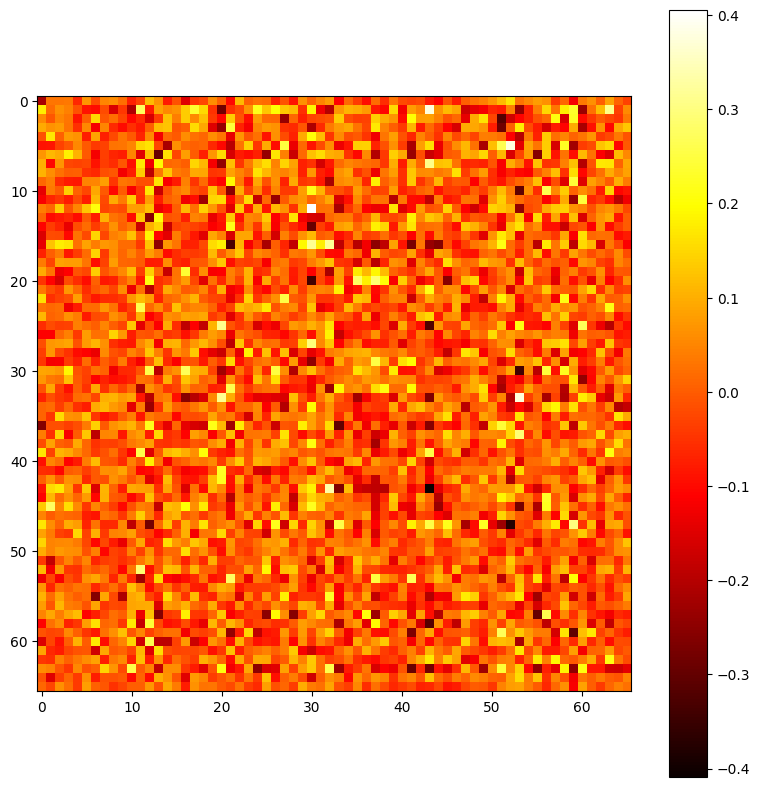

In [394]:
attn = model.blocks[0].attn
all_token_embeddings = model.embed(range(D_VOCAB))

embeddings_key = einsum("d_vocab d_model, n_heads d_model d_head -> n_heads d_vocab d_head", 
                        all_token_embeddings, attn.W_K) 
embeddings_query = einsum("d_vocab d_model, n_heads d_model d_head -> n_heads d_vocab d_head", 
                          all_token_embeddings, attn.W_Q) 
                          
plt.rcParams['figure.figsize'] = [20, 10]
qk_circuit_attn_heatmap = einsum(
    "n_heads d_vocab_q d_head, n_heads d_vocab_k d_head -> ... d_vocab_q d_vocab_k", 
    embeddings_query, embeddings_key
    ).detach().cpu().numpy()
fig, ax = plt.subplots(figsize=(8, 8))
graph = ax.imshow(qk_circuit_attn_heatmap, cmap="hot", interpolation="nearest")
plt.colorbar(graph)
plt.tight_layout()